In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
from ephys_queries import db_setup_core, select_spike_times
from dotenv import load_dotenv
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
data_dir = Path(".").absolute().parent / "data"
fig_dir = Path(".").absolute().parent / "figs"

In [147]:
df = (
    pd.read_csv(data_dir / "baseline.csv")
    .loc[lambda x: 
         (x["group_name"].isin((
            "acute_citalopram", 
            "acute_cit", 
                ))
        ) & (
         x["cluster"] != "no_baseline")]
)

In [158]:
group_names = ["acute_citalopram", "acute_cit"]
block_name = "chal"
t_before=300
fs = 30000

load_dotenv()
engine, metadata = db_setup_core()

session_names = df["session_name"].unique()
session = np.random.choice(session_names, 1)[0]

In [160]:
session_names

array(['hamilton_10', 'hamilton_04', 'hamilton_09', 'hamilton_31',
       'hamilton_38', 'hamilton_36', 'acute_01'], dtype=object)

In [159]:
(
    df[["neuron_id", "session_name","cluster"]]
    .groupby(['session_name', "cluster"])
    .apply(len)
    .reset_index()
    .loc[lambda x: x["session_name"]==session]
)

,session_name,cluster,0
15,hamilton_38,fast_firing,2
16,hamilton_38,slow_irregular,21
17,hamilton_38,slow_regular,4


In [227]:
session = "hamilton_36"
# session= "hamilton_09"

In [228]:
df_spikes = (
    select_spike_times(
        engine, metadata, 
        block_name=block_name, 
        group_names=group_names,
        session_names=[session],
        t_before=t_before,
        align_to_block=True
    )
    .assign(
        spiketimes= lambda x: x["spike_time_samples"].divide(fs)
    )
)

In [229]:
df_spikes = df_spikes.merge(df[["cluster", "neuron_id"]])

In [230]:
from spiketimes.df.conversion import df_to_list


_, slow_regs = df_to_list(df_spikes[df_spikes["cluster"] == "slow_regular"],
               spiketimes_col="spiketimes",
               spiketrain_col="neuron_id")

_, slow_irregs = df_to_list(df_spikes[df_spikes["cluster"] == "slow_irregular"],
               spiketimes_col="spiketimes",
               spiketrain_col="neuron_id")

_, ffs = df_to_list(df_spikes[df_spikes["cluster"] == "fast_firing"],
               spiketimes_col="spiketimes",
               spiketrain_col="neuron_id")

In [231]:
len(ffs)

4

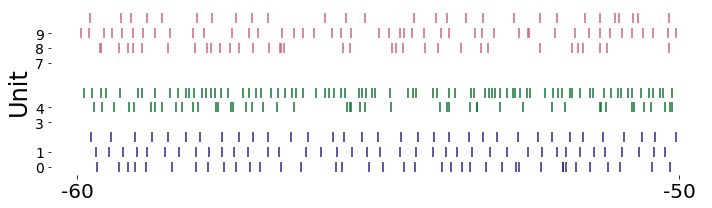

In [232]:
import matplotlib.pyplot as plt
from spiketimes.plots import grouped_raster

f, ax = plt.subplots(figsize=(10, 3))

t_start = -30
t_stop = t_start + 10

ax = grouped_raster([slow_regs[:3], ffs[:2], slow_irregs[:4]],
                    ["#332288", "#117733", "#CC6677"],
               t_start=t_start, t_stop=t_stop,
                    space_between_groups=1,
               plot_kwargs={"s":90},
                   ax=ax, skip_empty=False)
ax.set_yticks(ticks=[0, 1, 3, 4, 7, 8, 9])
ax.set_yticklabels([0, 1, 3, 4, 7, 8, 9], fontsize=14)

ax.set_xticks(ticks=[t_start, t_stop])
ax.set_xticklabels([-60, -50], fontsize=20)

ax.set(frame_on=False)

ax.set_ylabel("Unit", fontsize=24)
ax.set_xlabel("")

plt.tight_layout()
# plt.savefig(fig_dir / "drug_raster_1.svg", dpi=300, transparent=True)

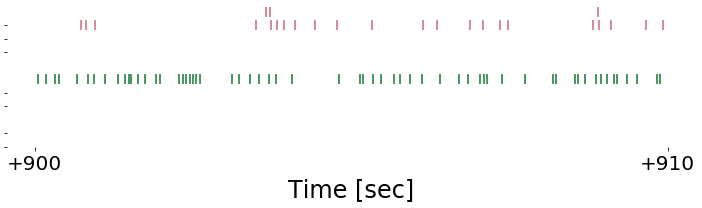

In [233]:
import matplotlib.pyplot as plt
from spiketimes.plots import grouped_raster

f, ax = plt.subplots(figsize=(10, 3))

t_start = 900
t_stop = t_start + 10

ax = grouped_raster([slow_regs[:3], ffs[:2], slow_irregs[6:10]],
                    ["#332288", "#117733", "#CC6677"],
               t_start=t_start, t_stop=t_stop,
                    space_between_groups=1,
               plot_kwargs={"s":90},
                   ax=ax, skip_empty=False)
ax.set_yticks(ticks=[0, 1, 3, 4, 7, 8, 9])
ax.set_yticklabels([], fontsize=14)

ax.set_xticks(ticks=[900, 910])
ax.set_xticklabels(["+900", "+910"], fontsize=20)

ax.set(frame_on=False)

ax.set_ylabel("", fontsize=24)
ax.set_xlabel("Time [sec]", fontsize=24)

plt.tight_layout()
# plt.savefig(fig_dir / "drug_raster_2.svg", dpi=300, transparent=True)

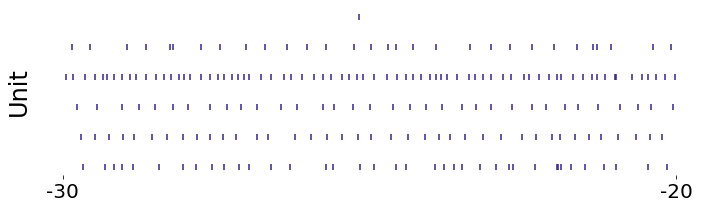

In [255]:
from spiketimes.plots import raster

t_start = -30
t_stop = t_start + 10

f, ax = plt.subplots(figsize=(10, 3))

ax = raster(slow_regs[:], 
            t_start=t_start, t_stop=t_stop, ax=ax, skip_empty=False,
            color="#332288")

ax.set_xticks(ticks=[t_start, t_stop])
ax.set_xticklabels([-30, -20], fontsize=20)

ax.set_yticks([])

ax.set(frame_on=False)

ax.set_ylabel("Unit", fontsize=24)
ax.set_xlabel("")

plt.tight_layout()
plt.savefig(fig_dir / "sr_drug_raster_1.svg", dpi=300, transparent=True)

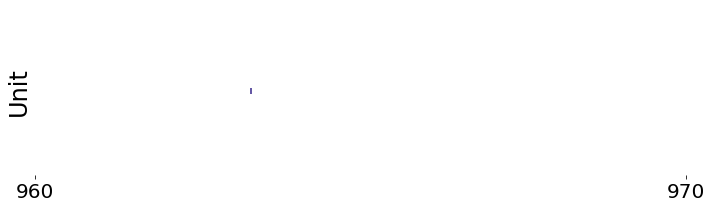

In [249]:
from spiketimes.plots import raster

t_start = 960
t_stop = t_start + 10

f, ax = plt.subplots(figsize=(10, 3))

ax = raster(slow_regs[:], 
            t_start=t_start, t_stop=t_stop, 
            ax=ax, skip_empty=False,
            color="#332288")

ax.set_xlim([t_start, t_stop])
ax.set_xticks(ticks=[t_start, t_stop])
ax.set_xticklabels([t_start, t_stop], fontsize=20)

ax.set_yticks([])

ax.set(frame_on=False)

ax.set_ylabel("Unit", fontsize=24)
ax.set_xlabel("")

plt.tight_layout()
plt.savefig(fig_dir / "sr_drug_raster_2.svg", dpi=300, transparent=True)

In [201]:
list(map(max, slow_regs))

[1135.9073666666666,
 1200.4609333333333,
 962.7195333333333,
 1174.0632,
 935.7653333333334]

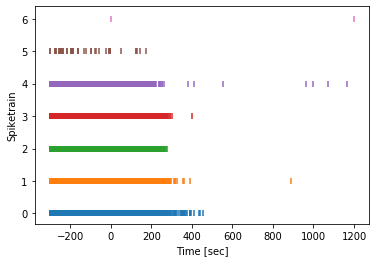

In [242]:
raster(slow_regs)

In [39]:
t_stop

-180